In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
SaveFigs = False

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [3]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

In [4]:
def get_block_lengths(p_reward_trial, p_reward_block):
    block_switch_trial = [0]
    for block_ind in range(p_reward_block.shape[1]):
        trials = np.where((p_reward_trial[0] == p_reward_block[0, block_ind]) & 
                          (p_reward_trial[1] == p_reward_block[1, block_ind]) &
                          [False if t<block_switch_trial[-1] else True for t in range(p_reward_trial.shape[1])])[0]
        # print(f'{block_ind}: {trials}')
        # print(f' {np.where(np.diff(trials) > 1)}')
        if len(np.where(np.diff(trials) > 1)[0])>0:
            trials_first_switch_ind = np.where(np.diff(trials) > 1)[0][0] + 1
            block = trials[: trials_first_switch_ind]
        else:
            block = trials
        # print(f' {block}')
        block_switch_trial.append(block[-1]+1)
    
    block_switch_trial = np.array(block_switch_trial)
    block_lengths = np.diff(block_switch_trial)

    return block_lengths, block_switch_trial


def gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths, 
                          block_generator_spread=5, seed=None, plot=False):
    
    p_reward_gen = np.empty((p_reward_trial.shape[0], p_reward_trial.shape[1]+1))
    print(f'p_reward_block shape: {p_reward_block.shape}')
    print(f'p_reward_gen shape: {p_reward_gen.shape}')

    # generate new block lengths
    if seed:
        np.random.seed(seed)
    
    not_all_positive = True
    while not_all_positive:
        block_length_generator = np.rint(np.random.uniform(
                                            -1*block_generator_spread+0.1, 
                                            block_generator_spread+0.1, 
                                            size=len(block_lengths)-1)).astype(np.int)
        block_length_generator = np.append(block_length_generator, -1*np.sum(block_length_generator))
        block_lengths_gen = (block_lengths + block_length_generator).astype(np.int)
        not_all_positive = np.any(block_lengths_gen<=0)
        
    print(f'original block lengths: {block_lengths}')
    print(f'generated new block length: {block_lengths_gen}')
    print(f'check total trial number: {np.sum(block_lengths_gen)}')
    
    # generate new p_reward arr
    for i in range(p_reward_trial.shape[0]):
        for block_gen_ind in range(len(block_lengths_gen)):
            if block_gen_ind == 0:
                p_reward_gen[i, 0:block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
            else:
                t_start = np.sum(block_lengths_gen[:block_gen_ind])
                p_reward_gen[i, t_start:t_start+block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
        p_reward_gen[i, -1] = p_reward_gen[i, -2]

    if plot:
        sides = ['left', 'right']
        colors = ['r', 'b']
        plt.figure(figsize=(8,4), dpi=150)
        for i in range(p_reward_trial.shape[0]):
            plt.plot(p_reward_trial[i], color=colors[i], label=f'original {sides[i]}')
            plt.plot(p_reward_gen[i], color=colors[i], linestyle='--', label=f'generated {sides[i]}')
            plt.title(f'Generated reward rate blocks')
            plt.xlabel('trial')
            plt.ylabel('reward_rate')
        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.tight_layout()
            
    return p_reward_gen, block_lengths_gen

### generate session action-reward sequence

In [5]:
key = {'subject_id': 482353, 'session': 38, 'model_id': 10}

In [6]:
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

In [7]:
# get session history

# get more exp session info by
# dj.ERD(experiment)

p_reward_block_df = pd.DataFrame((experiment.SessionBlock.WaterPortRewardProbability() & key).fetch())
p_reward_block_left = p_reward_block_df[p_reward_block_df['water_port']=='left'].sort_values(by='block')['reward_probability'].values
p_reward_block_right = p_reward_block_df[p_reward_block_df['water_port']=='right'].sort_values(by='block')['reward_probability'].values
p_reward_block = np.vstack((p_reward_block_left, p_reward_block_right)).astype(np.float)

blocks = np.unique(p_reward_block_df['block'].values)
if np.max(blocks) != len(blocks):
    raise ValueError('missing blocks!')
else:
    n_blocks = len(blocks)

# trial_reward_availability = pd.DataFrame((experiment.TrialAvailableReward() & key ).fetch())
# block_lengths, _ = np.histogram((experiment.SessionBlock.BlockTrial & key).fetch('block'), bins=np.arange(1, n_blocks+2))
# print(f'check sum of block len: {np.sum(block_lengths)} vs total trials {len(trial_reward_availability)/2}')

# if needed
# choice_outcome_sequence = pd.DataFrame((experiment.WaterPortChoice.proj(choice='water_port') * experiment.BehaviorTrial.proj('outcome', 'early_lick') & key).fetch())
# experiment.BehaviorTrial() & 'subject_id=482353' & 'session=38'

choice_history, reward_history, _, p_reward_trial, q_choice_outcome = foraging_model.get_session_history(key, remove_ignored=True)

block_lengths, _ = get_block_lengths(p_reward_trial, p_reward_block)
block_length_avg = np.average(block_lengths)
block_length_std = np.std(block_lengths)
# print(f'block length: avg - {block_length_avg}, std - {block_length_std}')

In [38]:
'''
block_lengths, _ = get_block_lengths(p_reward_trial, p_reward_block)
p_reward_gen, block_lengths_gen = gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths)
print(block_lengths_gen)
print(p_reward_gen.shape)
'''

p_reward_block shape: (2, 11)
p_reward_gen shape: (2, 469)
original block lengths: [18 43 58 72 46 62 60 48 40 19  2]
generated new block length: [22 44 56 74 43 57 56 48 38 19 11]
check total trial number: 468
[22 44 56 74 43 57 56 48 38 19 11]
(2, 469)


In [8]:
# get fitted model

# get more fitted model info
# dj.ERD(foraging_model)
# dj.ERD(foraging_model.FittedSessionModel) + 1
# foraging_model.Model() * foraging_model.Model.Param() & 'model_id=10'
# (foraging_model.FittedSessionModel.key_source & 'model_id=10' & 'subject_id=482353' & 'session=38').fetch('fit_cmd')
# foraging_model.Model() * foraging_model.Model.Param() & 'model_id=10'
# foraging_model.ModelClass()

model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
model_para_dict = {}
for i in range(len(model_para)):
    model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
    
forager = bandit_model.BanditModel(forager='LNP_softmax', n_trials=int((p_reward_trial).shape[1]), 
                                   **model_para_dict)
for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 468
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]


In [9]:
block_length_avg = np.average(block_lengths)
block_length_std = np.std(block_lengths)

forager.generate_p_reward(block_length_avg, block_length_std)

for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')


forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 468
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 10
p_reward: [[0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.3857 0.3857 0.3857
  0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857
  0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857
  0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.05   0.05
  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
  0.05   0.05   0.05   0.05   

In [10]:
forager.simulate()

for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 468
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 7
p_reward: [[0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643
  0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.0643 0.3857 0.3857 0.3857
  0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857 0.3857
  0.3857 0.3857 0

In [ ]:
q_est = forager.q_estimation


p_reward_block shape: (2, 11)
p_reward_gen shape: (2, 469)
original block lengths: [18 43 58 72 46 62 60 48 40 19  2]
generated new block length: [17 40 58 74 49 59 62 46 37 15 11]
check total trial number: 468
forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 468
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 11
p_reward: [[0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 

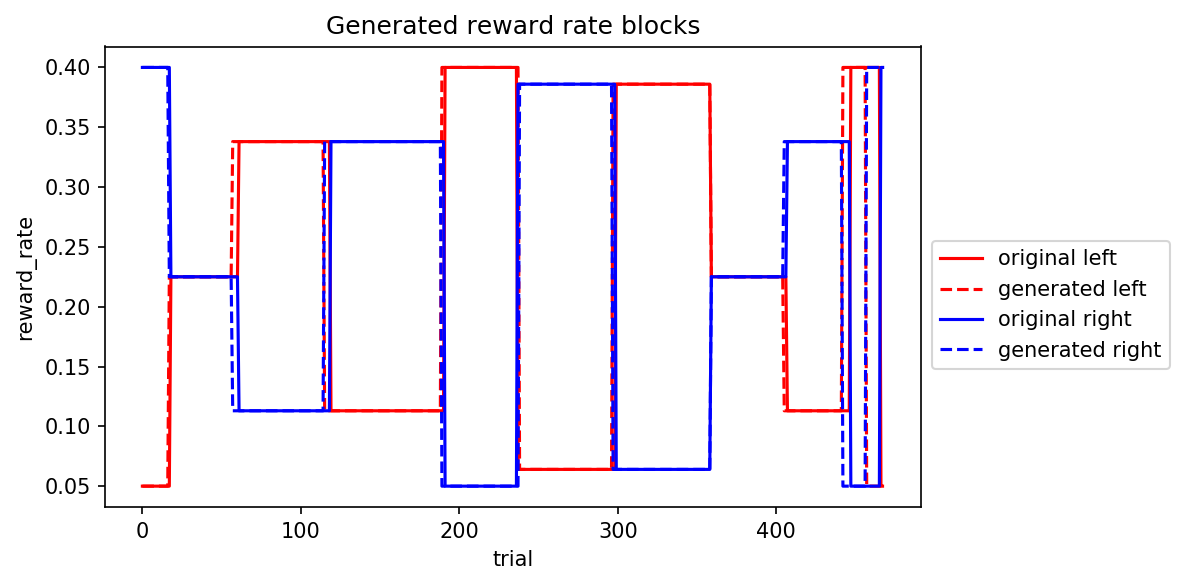

In [52]:
# forager.generate_p_reward(block_length_avg, block_length_std)
p_reward_gen, block_lengths_gen = gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths, plot=True)
forager.n_blocks = len(block_lengths)
forager.p_reward = p_reward_gen
forager.block_size = block_lengths_gen
forager.p_reward_fraction = p_reward_gen[1]/ np.sum(p_reward_gen, axis=0)
forager.p_reward_ratio = p_reward_gen[1]/ p_reward_gen[0]

for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 468
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 11
p_reward: [[0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225
  0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.225 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.338
  0.338 0.338 0.338 0.338 0.338 0.338 0.338 0.113 0.113 0.113 0.113 0.1

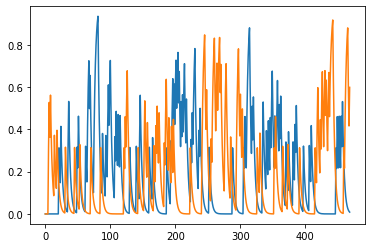

In [53]:
# generative mode
# Initialization
forager.time = 0

# All latent variables have n_trials + 1 length to capture the update after the last trial (HH20210726)
forager.q_estimation = np.full([forager.K, forager.n_trials+1], np.nan)
forager.q_estimation[:, 0] = 0

forager.choice_prob = np.full([forager.K, forager.n_trials+1], np.nan)
forager.choice_prob[:, 0] = 1/forager.K   # To be strict (actually no use)

forager.choice_history = np.zeros(
                [1, forager.n_trials+1], dtype=int)  # Choice history
# Reward history, separated for each port (Corrado Newsome 2005)
forager.reward_history = np.zeros([forager.K, forager.n_trials+1])

forager.reward_available = np.zeros([forager.K, forager.n_trials+1])
forager.reward_available[:, 0] = (np.random.uniform(0, 1, forager.K) < forager.p_reward[:, forager.time]).astype(int)

if forager.forager in ['LNP_softmax', 'LNP_softmax_CK']:
    # Compute the history filter. Compatible with any number of taus.
    # Use the full length of the session just in case of an extremely large tau.
    reversed_t = np.flipud(np.arange(forager.n_trials+1))
    forager.history_filter = np.zeros_like(reversed_t).astype('float64')
    for tau, w_tau in zip(forager.taus, forager.w_taus):
        # Note the normalization term (= tau when n -> inf.)
        forager.history_filter += w_tau * \
                                  np.exp(-reversed_t / tau) / \
                                  np.sum(np.exp(-reversed_t / tau))

for t in range(forager.n_trials):
    action = forager.act()
    forager.step(action)

# forager.simulate()
for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

plt.plot(forager.q_estimation[0])
plt.plot(forager.q_estimation[1])

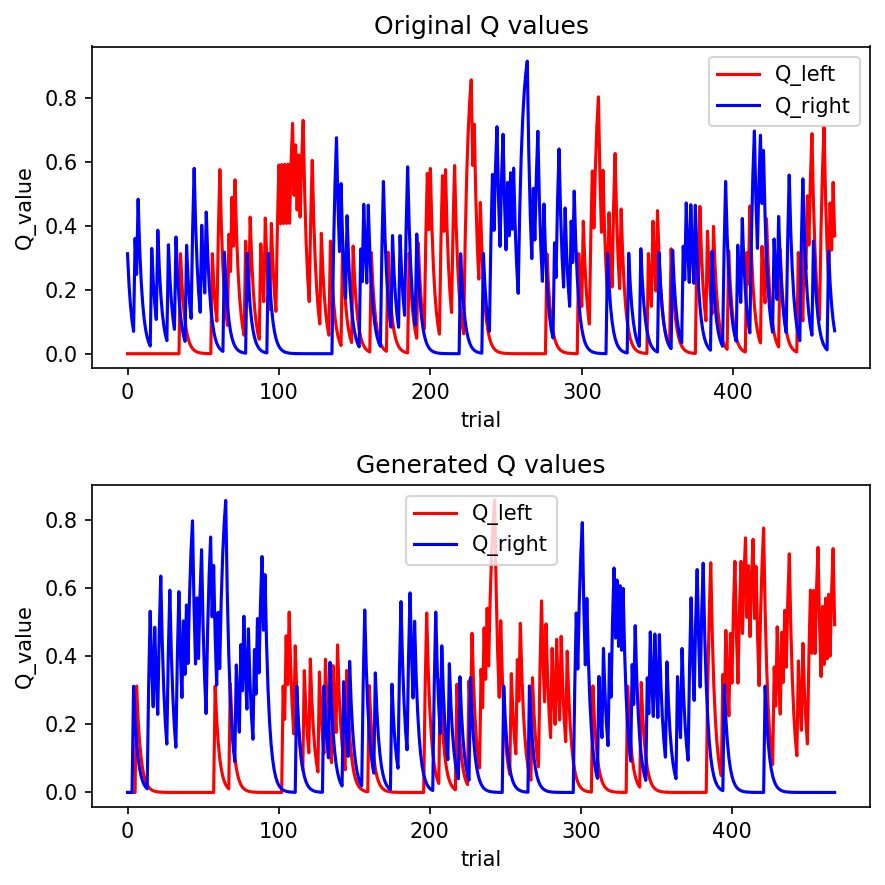

In [11]:
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)


qs = ['Q_left', 'Q_right']
colors = ['r', 'b']
fig, axs = plt.subplots(2,1, figsize=(6,6), dpi=150)
for i, q in enumerate(qs):
    axs[0].plot(df_Qs[df_Qs['session']==key['session']][q].values, color=colors[i], label=q)
    axs[1].plot(forager.q_estimation[i], color=colors[i], label=q)
axs[0].set_title('Original Q values')
axs[1].set_title('Generated Q values')
for j in range(len(axs)):
    axs[j].set_xlabel('trial')
    axs[j].set_ylabel('Q_value')
    axs[j].legend(loc='best')
plt.tight_layout()
